<a href="https://colab.research.google.com/github/aakashpaul-2/Machine-Learning-Projects/blob/main/pyTorch_pecommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The modified version is:

* Faster

* Finds a better answer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [ ]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2020-05-26 16:54:02--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  22.4MB/s    in 8.8s    

2020-05-26 16:54:12 (21.6 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [ ]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [ ]:
!ls

ml-20m	ml-20m.zip  sample_data


In [ ]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
# set our own ids
current_user_id = 0
custom_user_map = {} # old user id > new user id
def map_user_id(row):
  global current_user_id, custom_user_map
  old_user_id = row['userId']
  if old_user_id not in custom_user_map:
    custom_user_map[old_user_id] = current_user_id
    current_user_id += 1
  return custom_user_map[old_user_id]

df['new_user_id'] = df.apply(map_user_id, axis=1)

In [ ]:
# Now do the same thing for movie ids
current_movie_id = 0
custom_movie_map = {} # old movie id > new movie id
def map_movie_id(row):
  global current_movie_id, custom_movie_map
  old_movie_id = row['movieId']
  if old_movie_id not in custom_movie_map:
    custom_movie_map[old_movie_id] = current_movie_id
    current_movie_id += 1
  return custom_movie_map[old_movie_id]

df['new_movie_id'] = df.apply(map_movie_id, axis=1)

In [ ]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [ ]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [ ]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0, 1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
  
  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)

    # merge
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [ ]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(
        train_users, train_movies, train_ratings
    )

    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    # we could do this if the test set size was manageable
    # test_outputs = model(test_users, test_movies)
    # test_loss = criterion(test_outputs, test_ratings).item()
    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]

      # conver to tensor
      users = torch.from_numpy(users).long()
      movies = torch.from_numpy(movies).long()
      targets = torch.from_numpy(targets)
    
      # reshape targets
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      outputs = model(users, movies)
      loss = criterion(outputs, targets).item()
      test_loss.append(loss)
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [ ]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model,
    criterion,
    optimizer,
    (train_users, train_movies, train_ratings),
    (test_users, test_movies, test_ratings),
    10)

Epoch 1/10, Train Loss: 0.7381, Test Loss: 0.6941, Duration: 0:00:51.489272
Epoch 2/10, Train Loss: 0.6718, Test Loss: 0.6681, Duration: 0:00:50.002633
Epoch 3/10, Train Loss: 0.6404, Test Loss: 0.6593, Duration: 0:00:49.744524
Epoch 4/10, Train Loss: 0.6174, Test Loss: 0.6407, Duration: 0:00:49.743073
Epoch 5/10, Train Loss: 0.5988, Test Loss: 0.6312, Duration: 0:00:49.679029
Epoch 6/10, Train Loss: 0.5847, Test Loss: 0.6302, Duration: 0:00:49.381665
Epoch 7/10, Train Loss: 0.5742, Test Loss: 0.6261, Duration: 0:00:49.917805
Epoch 8/10, Train Loss: 0.5665, Test Loss: 0.6241, Duration: 0:00:49.661083
Epoch 9/10, Train Loss: 0.5604, Test Loss: 0.6234, Duration: 0:00:49.287961
Epoch 10/10, Train Loss: 0.5556, Test Loss: 0.6252, Duration: 0:00:49.463753


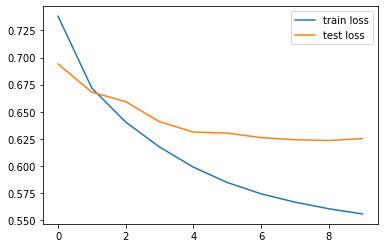

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
ratings

array([ 0.5,  2. , -1.5, ...,  1.5,  2. ,  0.5])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving training_2.csv to training_2.csv


In [ ]:
df_1 = pd.read_csv("training_2.csv")

In [ ]:
df_1.head()

,user_id,movieId,ratings,new_user_id
0,1,1,5.0,0
1,1,2,4.0,0
2,1,3,0.0,0
3,1,4,0.0,0
4,1,5,0.0,0


In [ ]:
df_1.user_id = pd.Categorical(df_1.user_id)
df_1['new_user_id'] = df_1.user_id.cat.codes

In [ ]:
len(df_1)

62423